<div style="text-align: center; background-color: #0A6EBD; font-family: 'Trebuchet MS', Arial, sans-serif; color: white; padding: 
    20px; font-size: 40px; font-weight: bold; border-radius: 0 0 0 0; box-shadow: 0px 6px 8px rgba(0, 0, 0, 0.2);">
  PROJECT 2: Decision Tree
</div>

<div style="text-align: center; background-color: #5A96E3; font-family: 'Trebuchet MS', Arial, sans-serif; color: white; padding: 20px; font-size: 40px; font-weight: bold; border-radius: 0 0 0 0; box-shadow: 0px 6px 8px rgba(0, 0, 0, 0.2);">
  Wine Quality Dataset 

</div>

## **TẢI THƯ VIỆN CẦN THIẾT**

In [14]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import graphviz
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

## **ĐỌC DỮ LIỆU**

### Loading data from `.csv` file

In [15]:
wine_data = pd.read_csv('winequality-white.csv', sep=';')

### Dataset Information

In [16]:
print("\nDataset Information :")
print(wine_data.info())


Dataset Information :
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4898 entries, 0 to 4897
Data columns (total 12 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   fixed acidity         4898 non-null   float64
 1   volatile acidity      4898 non-null   float64
 2   citric acid           4898 non-null   float64
 3   residual sugar        4898 non-null   float64
 4   chlorides             4898 non-null   float64
 5   free sulfur dioxide   4898 non-null   float64
 6   total sulfur dioxide  4898 non-null   float64
 7   density               4898 non-null   float64
 8   pH                    4898 non-null   float64
 9   sulphates             4898 non-null   float64
 10  alcohol               4898 non-null   float64
 11  quality               4898 non-null   int64  
dtypes: float64(11), int64(1)
memory usage: 459.3 KB
None


We need to check for missing values ​​of the dataset.

In [17]:
print("\nMissing values of each column:")
print(wine_data.isnull().sum())


Missing values of each column:
fixed acidity           0
volatile acidity        0
citric acid             0
residual sugar          0
chlorides               0
free sulfur dioxide     0
total sulfur dioxide    0
density                 0
pH                      0
sulphates               0
alcohol                 0
quality                 0
dtype: int64


Dataset has no missing values.

## **1. CHUẨN BỊ DỮ LIỆU**

### 1.1 Phân loại rượu

In [18]:
def group_wine_quality(quality):
    if quality <= 4:
        return 0
    elif quality <= 6:
        return 1
    else:
        return 2

In [19]:
wine_data['quality_group'] = wine_data['quality'].apply(group_wine_quality)

### 1.2 Chuẩn bị dữ liệu đầu vào (features) và nhãn (target)

In [20]:
X = wine_data.drop(['quality', 'quality_group'], axis=1)
y = wine_data['quality_group']

### 1.3 Chia dữ liệu dựa theo các tỷ lệ 40/60, 60/40, 80/20, 90/10

In [21]:
def spliting_dataset(X, y, train_ratio, test_ratio):
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, train_size=train_ratio, test_size=test_ratio, stratify=y, shuffle=True, random_state=42)

    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)

    return X_train, X_test, y_train, y_test


In [22]:
def plot_class_distribution(y, y_train, y_test, train_ratio, test_ratio):
    plt.figure(figsize=(10, 5))
    plt.subplot(131)
    y.value_counts().plot(kind='bar', title='Original Set')
    plt.subplot(132)
    pd.Series(y_train).value_counts().plot(kind='bar', title=f'Train ({train_ratio*100}%)')
    plt.subplot(133)
    pd.Series(y_test).value_counts().plot(kind='bar', title=f'Test ({test_ratio*100}%)')
    plt.tight_layout()
    plt.show()



--- TRAIN/TEST = 40.0 / 60.0 ---


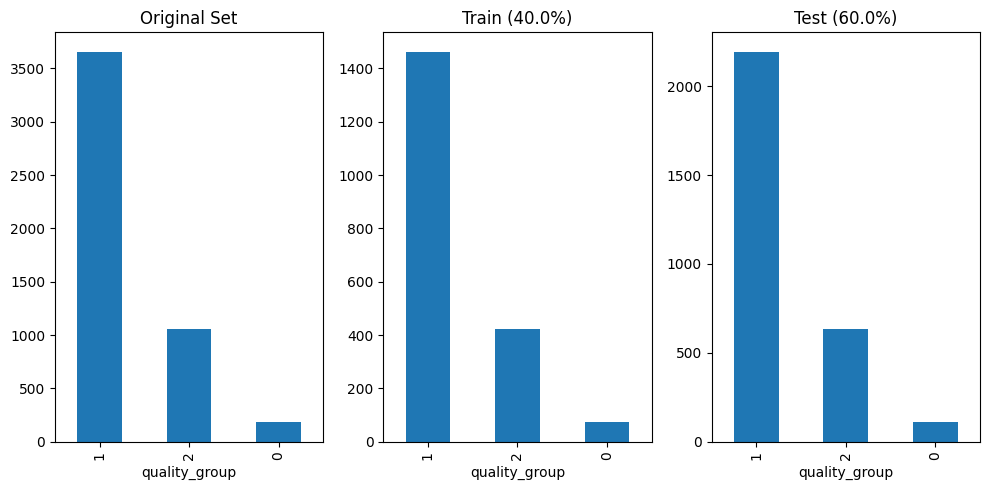


--- TRAIN/TEST = 60.0 / 40.0 ---


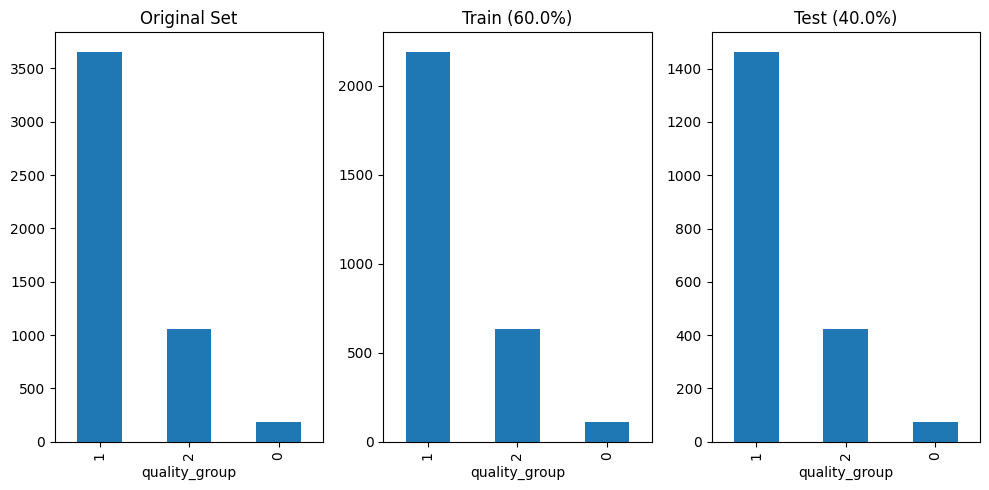


--- TRAIN/TEST = 80.0 / 20.0 ---


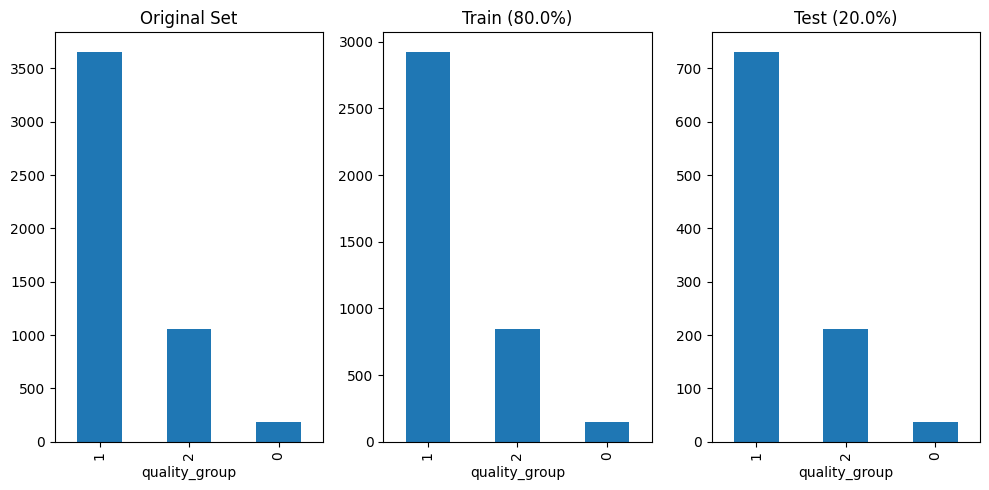


--- TRAIN/TEST = 90.0 / 10.0 ---


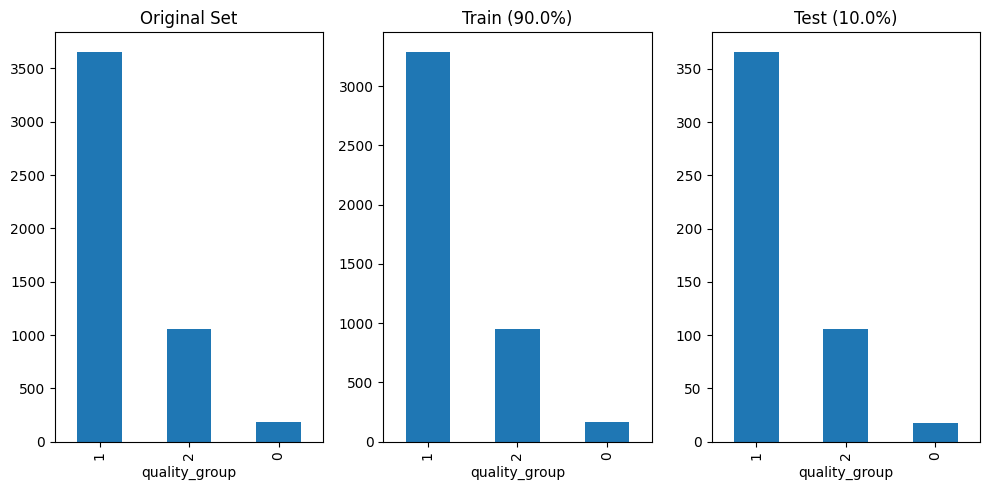

In [23]:
split_ratios = [(0.4, 0.6), (0.6, 0.4), (0.8, 0.2), (0.9, 0.1)]

feature_train = {}
label_train = {}
feature_test = {}
label_test = {}

for train_ratio, test_ratio in split_ratios:
    print(f"\n--- TRAIN/TEST = {train_ratio*100} / {test_ratio*100} ---")
    
    X_train, X_test, y_train, y_test = spliting_dataset(X, y, train_ratio, test_ratio)
    plot_class_distribution(y, y_train, y_test, train_ratio, test_ratio)

    feature_train[(train_ratio, test_ratio)] = X_train
    label_train[(train_ratio, test_ratio)] = y_train
    feature_test[(train_ratio, test_ratio)] = X_test
    label_test[(train_ratio, test_ratio)] = y_test


## **2. XÂY DỰNG CÂY QUYẾT ĐỊNH**

### 2.1 Tạo thư mục lưu trữ ảnh cây quyết định

In [24]:
output_dir = "Decision_Tree_Visualizations_WineQuality_Dataset"
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

### 2.2 Hàm xây dựng cây quyết định

In [25]:
def analyze_decision_tree(X_train, X_test, y_train, y_test, train_ratio, test_ratio, max_depth):
    clf = DecisionTreeClassifier(criterion='entropy', max_depth=max_depth, random_state=42)
    clf.fit(X_train, y_train)

    y_pred = clf.predict(X_test)

    print(f"\n--- Decision Tree with Train/Test = {train_ratio*100} / {test_ratio*100}, max_depth = {max_depth} ---")
    dot_data = export_graphviz(
        clf, out_file=None, filled=True, rounded=True,
        feature_names=X.columns, class_names=['Low', 'Medium', 'High'], special_characters=True
    )
    graph = graphviz.Source(dot_data)
    display(graph)
    
    file_name = f"{int(train_ratio*100)}-{int(test_ratio*100)}-max_depth={max_depth}.svg"
    output_path = os.path.join(output_dir, file_name)
    graph.render(filename=output_path, format='svg', cleanup=True)
    


### 2.3 Trực quan hóa cây quyết định với từng trường hợp tỷ lệ train/test

In [26]:
for train_ratio, test_ratio in split_ratios:
   
    X_train = feature_train[(train_ratio, test_ratio)]
    y_train = label_train[(train_ratio, test_ratio)]
    X_test = feature_test[(train_ratio, test_ratio)]
    y_test = label_test[(train_ratio, test_ratio)]
    
    analyze_decision_tree(X_train, X_test, y_train, y_test, train_ratio, test_ratio, None)



--- Decision Tree with Train/Test = 40.0 / 60.0, max_depth = None ---


ExecutableNotFound: failed to execute WindowsPath('dot'), make sure the Graphviz executables are on your systems' PATH

ExecutableNotFound: failed to execute WindowsPath('dot'), make sure the Graphviz executables are on your systems' PATH

## **3. ĐÁNH GIÁ**

### 3.1 Hàm khởi tạo bảng báo cáo (classification report) và ma trận nhầm lẫn  (confusion matrix)

In [14]:
def generate_classification_report_and_confusion_matrix(y_test, y_pred):
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred, target_names=['Low', 'Medium', 'High']))
    
    # Ma trận nhầm lẫn
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=['Low', 'Medium', 'High'], 
                yticklabels=['Low', 'Medium', 'High'])
    plt.title('Decision Tree Classifier Confusion Matrix')
    plt.xlabel('Predict Label')
    plt.ylabel('True Label')
    plt.show()


### 3.2 Trực quan hóa bảng báo cáo (classification report) và ma trận nhầm lẫn (confusion matrix)


--- TRAIN/TEST = 40.0 / 60.0 ---

Classification Report:
              precision    recall  f1-score   support

         Low       0.24      0.20      0.22       110
      Medium       0.84      0.83      0.84      2193
        High       0.55      0.58      0.57       636

    accuracy                           0.76      2939
   macro avg       0.54      0.54      0.54      2939
weighted avg       0.76      0.76      0.76      2939



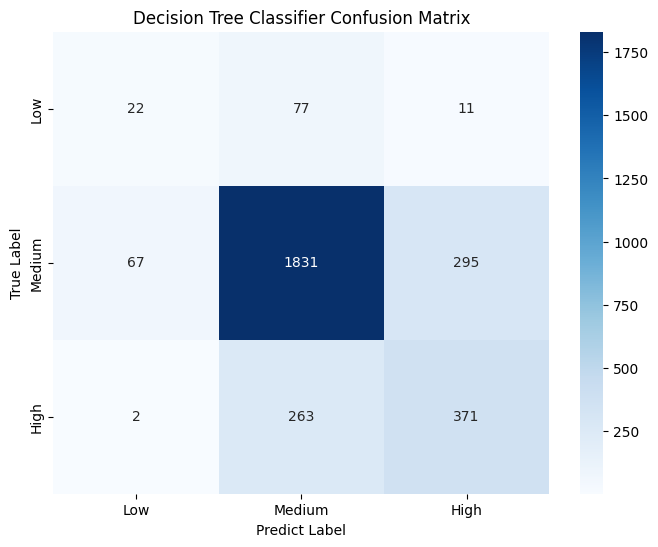


--- TRAIN/TEST = 60.0 / 40.0 ---

Classification Report:
              precision    recall  f1-score   support

         Low       0.24      0.27      0.26        73
      Medium       0.85      0.84      0.85      1463
        High       0.59      0.60      0.59       424

    accuracy                           0.77      1960
   macro avg       0.56      0.57      0.57      1960
weighted avg       0.77      0.77      0.77      1960



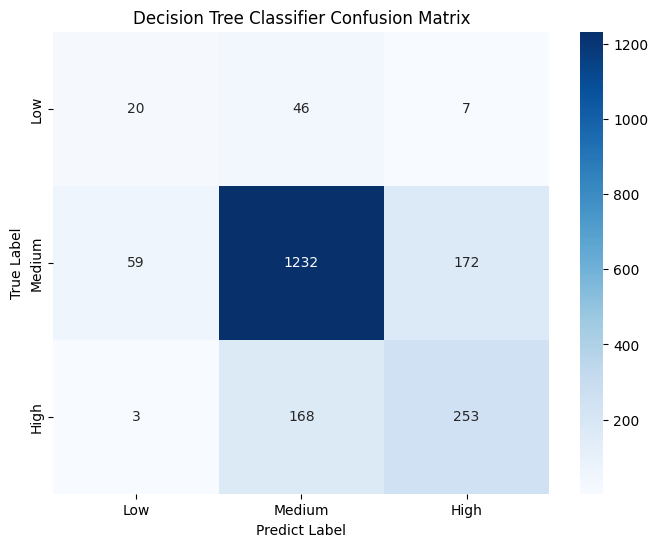


--- TRAIN/TEST = 80.0 / 20.0 ---

Classification Report:
              precision    recall  f1-score   support

         Low       0.32      0.38      0.35        37
      Medium       0.87      0.85      0.86       731
        High       0.62      0.63      0.63       212

    accuracy                           0.79       980
   macro avg       0.60      0.62      0.61       980
weighted avg       0.79      0.79      0.79       980



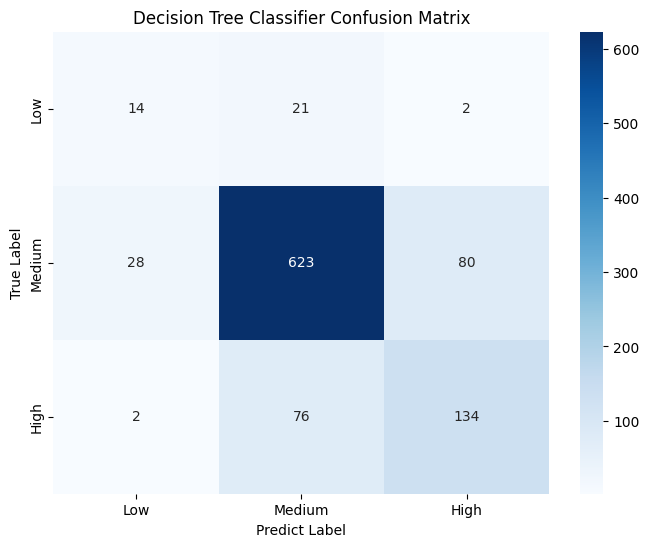


--- TRAIN/TEST = 90.0 / 10.0 ---

Classification Report:
              precision    recall  f1-score   support

         Low       0.32      0.44      0.37        18
      Medium       0.89      0.83      0.85       366
        High       0.60      0.71      0.65       106

    accuracy                           0.79       490
   macro avg       0.60      0.66      0.63       490
weighted avg       0.80      0.79      0.79       490



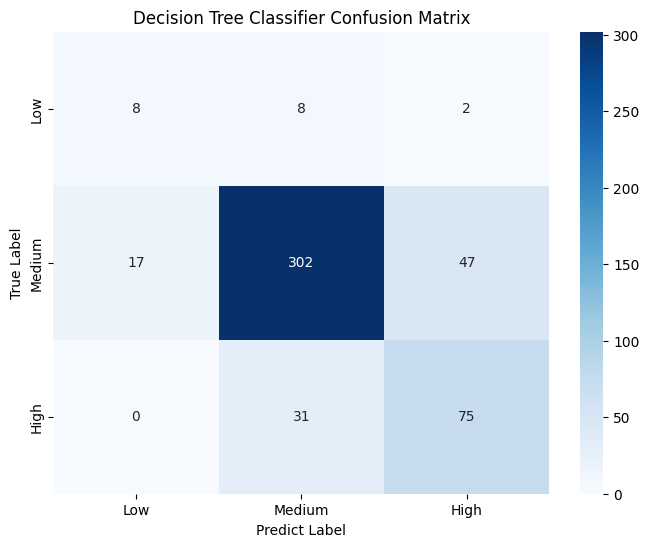

In [15]:
for train_ratio, test_ratio in split_ratios:
    print(f"\n--- TRAIN/TEST = {train_ratio*100} / {test_ratio*100} ---")
    
    X_train = feature_train[(train_ratio, test_ratio)]
    y_train = label_train[(train_ratio, test_ratio)]
    X_test = feature_test[(train_ratio, test_ratio)]
    y_test = label_test[(train_ratio, test_ratio)]

    clf = DecisionTreeClassifier(criterion='entropy', max_depth=None, random_state=42)
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    
    generate_classification_report_and_confusion_matrix(y_test, y_pred)


## **4. ĐỘ SÂU VÀ ĐỘ CHÍNH XÁC CỦA CÂY QUYẾT ĐỊNH**


--- Decision Tree with max_depth = None ---


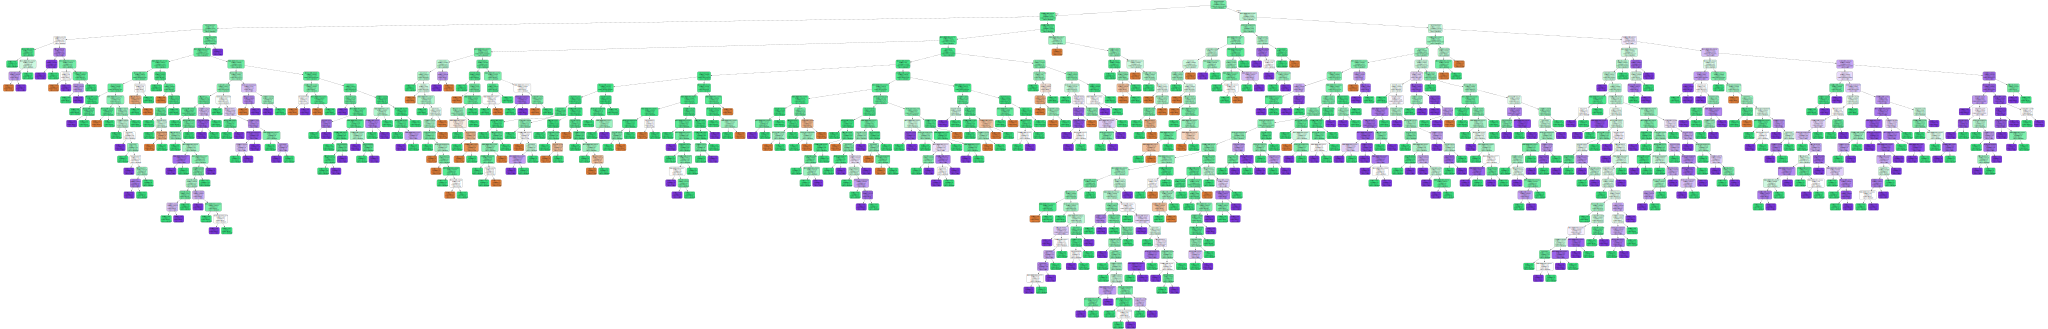


--- Decision Tree with max_depth = 2 ---


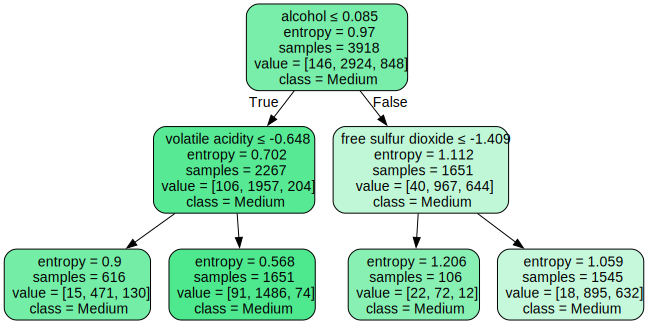


--- Decision Tree with max_depth = 3 ---


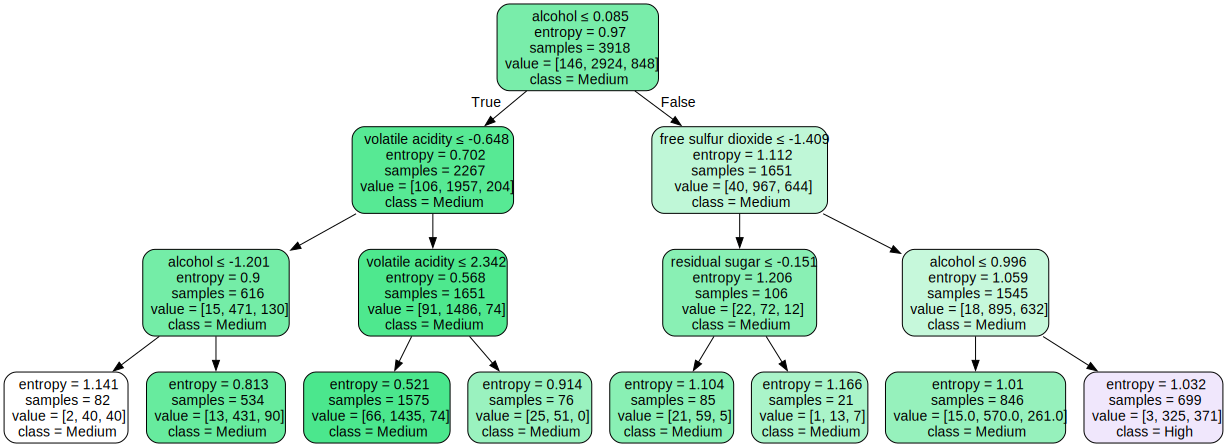


--- Decision Tree with max_depth = 4 ---


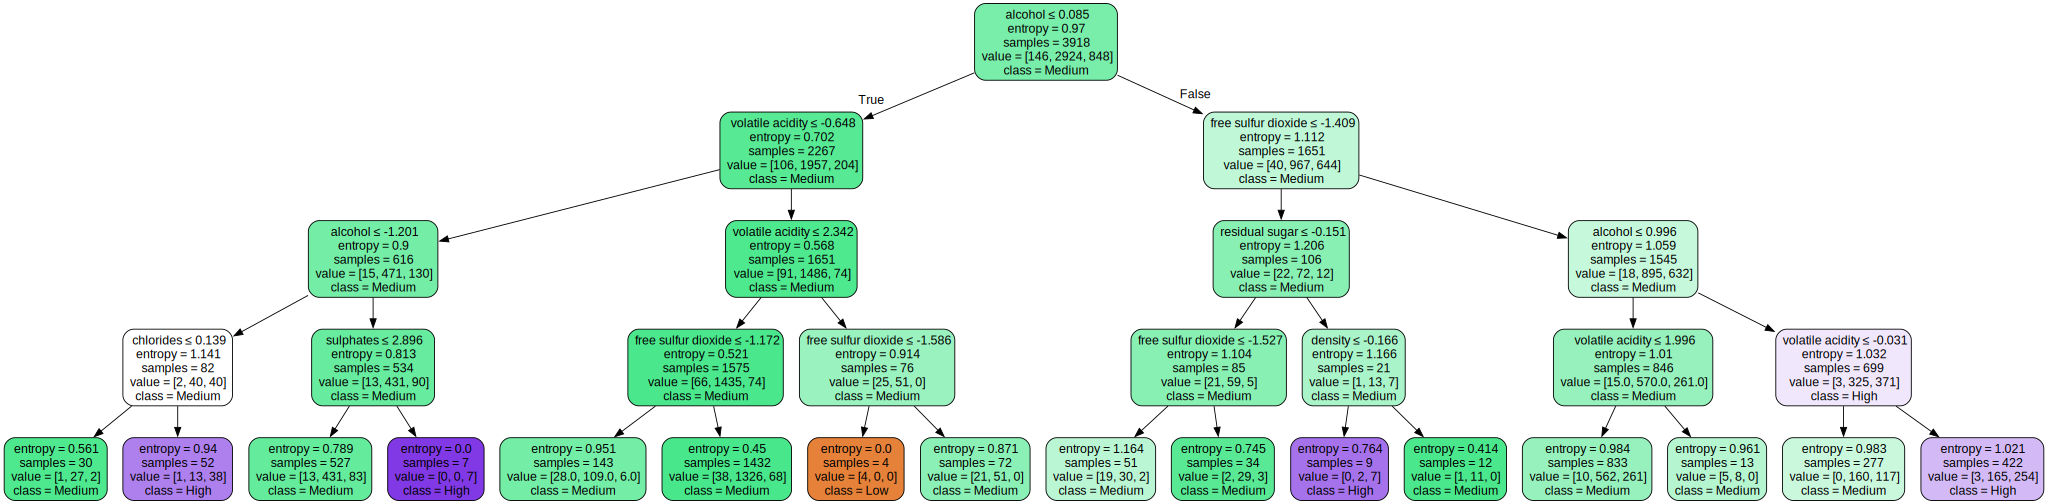


--- Decision Tree with max_depth = 5 ---


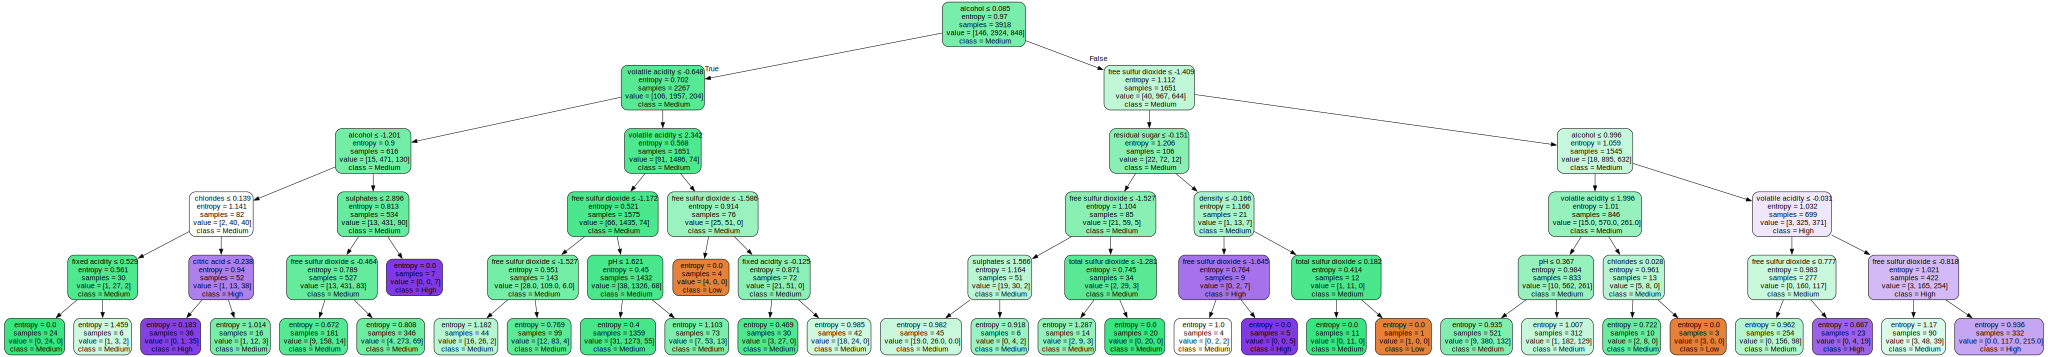


--- Decision Tree with max_depth = 6 ---


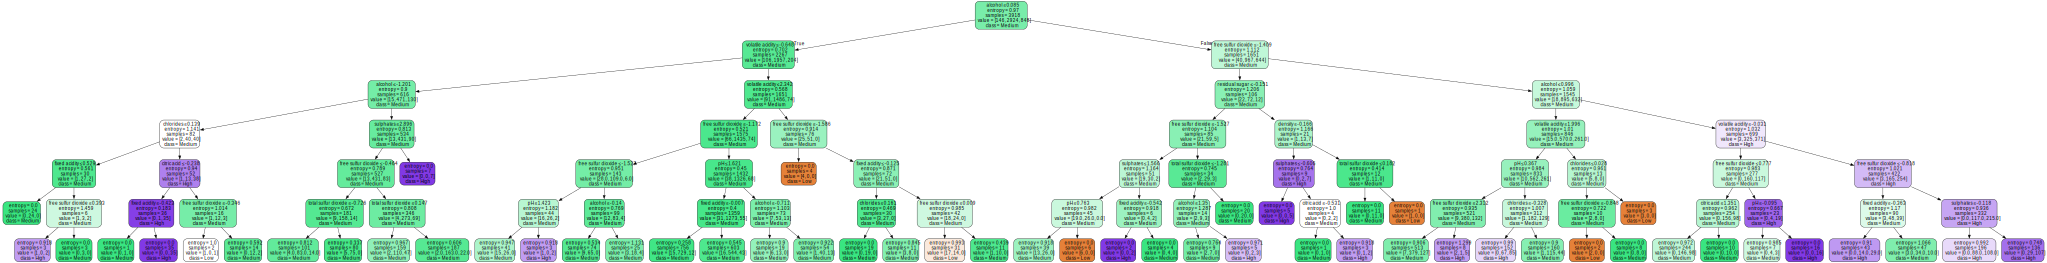


--- Decision Tree with max_depth = 7 ---


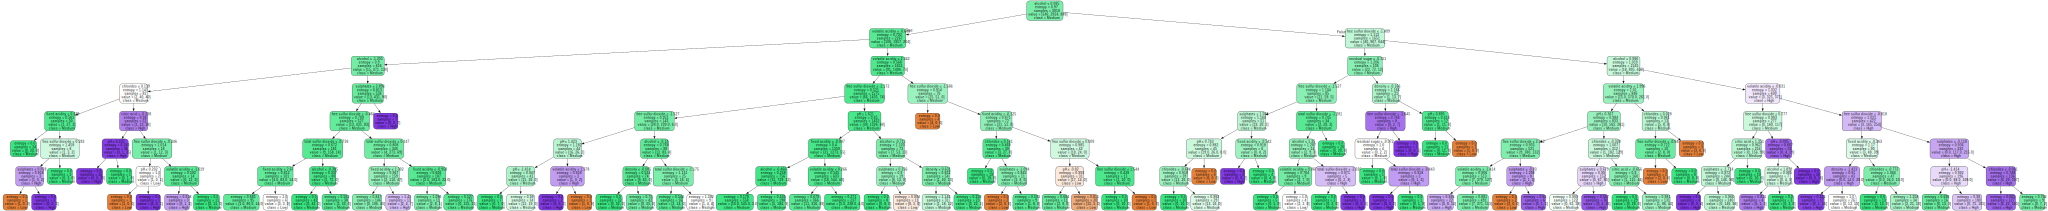


Accuracy for each max_depth:
  max_depth  accuracy
0      None  0.786735
1         2  0.745918
2         3  0.758163
3         4  0.757143
4         5  0.778571
5         6  0.765306
6         7  0.774490


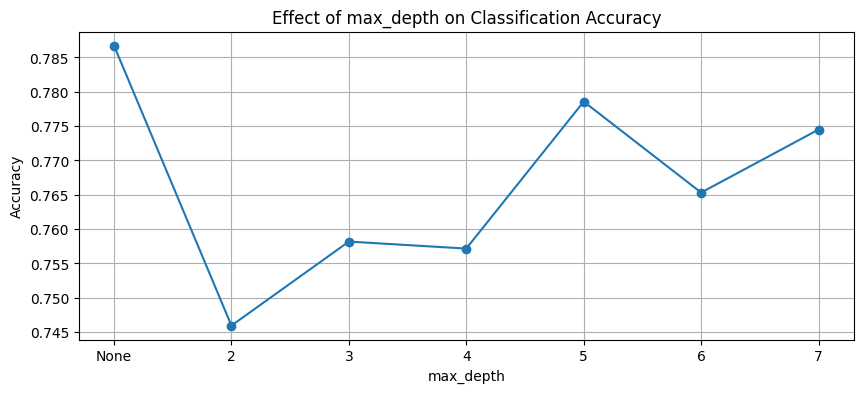

In [16]:
max_depth_values = [None, 2, 3, 4, 5, 6, 7]
accuracy_results = []

train_ratio = 0.8
test_ratio = 0.2
X_train, X_test, y_train, y_test = spliting_dataset(X, y, train_ratio, test_ratio)

for max_depth in max_depth_values:
    
    clf = DecisionTreeClassifier(criterion='entropy', max_depth=max_depth, random_state=42)
    clf.fit(X_train, y_train)

    y_pred = clf.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    accuracy_results.append(accuracy)

    print(f"\n--- Decision Tree with max_depth = {max_depth} ---")
    dot_data = export_graphviz(
        clf, out_file=None, filled=True, rounded=True,
        feature_names=X.columns, class_names=['Low', 'Medium', 'High'], special_characters=True
    )
    graph = graphviz.Source(dot_data)
    display(graph)

    file_name = f"{int(train_ratio*100)}-{int(test_ratio*100)}-max_depth={max_depth}.svg"
    output_path = os.path.join(output_dir, file_name)
    graph.render(filename=output_path, format='svg', cleanup=True)

max_depth_labels = ['None', 2, 3, 4, 5, 6, 7]
accuracy_df = pd.DataFrame({
    'max_depth': max_depth_labels,
    'accuracy': accuracy_results
})
print("\nAccuracy for each max_depth:")
print(accuracy_df)

plt.figure(figsize=(10, 4))
plt.plot(max_depth_labels, accuracy_results, marker='o')
plt.title('Effect of max_depth on Classification Accuracy')
plt.xlabel('max_depth')
plt.ylabel('Accuracy')
plt.grid(True)
plt.show()
